In this notebook, I perform Ramsey fringe experiment for the (01) and (12) subspace.

### References

[1]: M. J. Peterer *et al.* Coherence and Decay of Higher Energy Levels of a Superconducting Transmon Qubit. *Phys. Rev. Lett.* **114***, 010501 (2015). [https://doi.org/10.1103/PhysRevLett.114.010501](https://doi.org/10.1103/PhysRevLett.114.010501).

## Dependencies

In [31]:
import os
os.chdir('/Users/ngdnhtien/Research/Codespace/PulsatingPulseShop/')

# Necessary dependencies

# qiskit
import qiskit
import qiskit_ibm_provider

# qutritium
import utility as ut
import constant

# numerical
import numpy as np
import pickle 
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 1
%config InlineBackend.figure_formats = ['svg']

# Backend specifications

Throughout these experiments we'll use the `ibm_brisbane` processor, focusing on `qubit = 0`.

In [2]:
provider = qiskit_ibm_provider.IBMProvider()

In [3]:
backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 109
cbit = 0
num_qubits = int(qubit+1)
num_cbits = 1
weight = 1

In [4]:
rough_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value* constant.GHz
rough_12_freq = rough_01_freq + qubit_anharmonicty

print(r"f01 = "+f'{round(rough_01_freq/constant.GHz, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/constant.GHz, 4)}'+' GHz')

f01 = 4.985 GHz
f12 = 4.6779 GHz


In [5]:
reset_circuit = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
reset_circuit.measure(qubit, cbit)

reset_circuits = [reset_circuit, reset_circuit]

In [6]:
calibrations = backend_defaults.instruction_schedule_map
calibrations.get('x', qubit), calibrations.get('sx', qubit)

(Schedule((0, Play(Drag(duration=120, sigma=30, beta=-1.2974243905177958, amp=0.18151219398122395, angle=0.0, name='Xp_d109'), DriveChannel(109), name='Xp_d109')), name="x"),
 Schedule((0, Play(Drag(duration=120, sigma=30, beta=-1.2657716879582008, amp=0.09065353609936277, angle=0.008434973910643098, name='X90p_d109'), DriveChannel(109), name='X90p_d109')), name="sx"))

In [8]:
amp_sx01 = 0.09067120838183576
beta_sx01 = -1.2802230938112782

amp_sx12 = 0.12538583
dur_sx12 = 80
sig_sx12 = 20
beta_sx12 = -0.5

In [9]:
def sched_01(phi, amp, beta):
    '''
        Generating a rotation in 01 with an angle phi away from the x-axis
    '''
    with qiskit.pulse.build(backend=backend) as schedule:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_01_freq, drive_chan)
        with qiskit.pulse.phase_offset(phi, drive_chan):
            qiskit.pulse.play(qiskit.pulse.Drag(duration=120, amp=amp, sigma=30, beta=beta), drive_chan)
            
    return schedule

def sched_12(phi, amp, beta):
    '''
        Generating a rotation in 12 with an angle phi away from the x-axis
    '''
    with qiskit.pulse.build(backend=backend) as schedule:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
        with qiskit.pulse.phase_offset(phi, drive_chan):
            qiskit.pulse.play(qiskit.pulse.Drag(duration=dur_sx12, amp=amp_sx12, sigma=sig_sx12, beta=beta_sx12), drive_chan)
            
    return schedule

In [11]:
gate_sx12 = qiskit.circuit.Gate('SX12', weight, [])

ground_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
ground_circ.measure(qubit, cbit)

first_excited_state_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
first_excited_state_circ.x(qubit)
first_excited_state_circ.measure(qubit, cbit)

second_excited_state_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
second_excited_state_circ.x(qubit)
second_excited_state_circ.append(gate_sx12, [qubit])
second_excited_state_circ.append(gate_sx12, [qubit])
second_excited_state_circ.measure(qubit, cbit)
second_excited_state_circ.add_calibration(gate_sx12, [qubit], sched_12(0, amp_sx12, beta_sx12))

new_discrim = [ground_circ, first_excited_state_circ, second_excited_state_circ]

# Measurement of $\beta$

In [ ]:
ramsey_experiment_circuits = []

sx01 = qiskit.circuit.Gate('sx01', weight, [])
sx12_plus = qiskit.circuit.Gate('sx12_plus', weight, [])
sx12_minus = qiskit.circuit.Gate('sx12_minus', weight, [])
axial_01 = qiskit.circuit.Gate('axial_01', weight, [])

for reps in [5, 6, 7, 8, 9]:
    for phase_sweep in np.linspace(-np.pi/6, -np.pi/6+2*np.pi, 100):
        ramsey_circuit = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
        ramsey_circuit.append(sx01, [qubit])
        for i in range(reps):
            ramsey_circuit.append(sx12_plus, [qubit])
            ramsey_circuit.append(sx12_minus, [qubit])
        ramsey_circuit.append(axial_01, [qubit])
        ramsey_circuit.measure(qubit, cbit)
        ramsey_circuit.add_calibration(sx01, [qubit], sched_01(phi=0, amp=amp_sx01, beta=beta_sx01))
        ramsey_circuit.add_calibration(sx12_plus, [qubit], sched_12(phi=0, amp=+1*amp_sx12, beta=beta_sx12))
        ramsey_circuit.add_calibration(sx12_minus, [qubit], sched_12(phi=0, amp=-1*amp_sx12, beta=beta_sx12))
        ramsey_circuit.add_calibration(axial_01, [qubit], sched_01(phi=phase_sweep, amp=amp_sx01, beta=beta_sx01))
        ramsey_experiment_circuits.append(ramsey_circuit)

In [ ]:
ramsey_package = new_discrim + ramsey_experiment_circuits + reset_circuits
ramseyv1_job = backend.run(ramsey_package, meas_level=1, meas_return='single', shots=2048)
ramseyv1_job.job_id()

'crkp0kaakhw0008ewywg'

In [ ]:
ramseyv1_job.status()

<JobStatus.QUEUED: 'job is queued'>

In [ ]:
ramseyv1_job = provider.backend.retrieve_job('crkp0kaakhw0008ewywg')

ramseyv1_exp = ut.DataAnalysis(experiment=ramseyv1_job, average=False, shots=2048, qubit=0)
ramseyv1_exp.retrieve_data(average=False)
ramseyv1_exp.build_discrim()
ramseyv1_exp.count_pop()
ramseyv1_exp.error_mitiq()

In [29]:
with open('./experiment/ramseyv1/data/round3_23april24/beta/mitigated/56789.pkl', 'wb') as f:
    pickle.dump(np.array(ramseyv1_exp.mitiq_data)[3:-2], f)

# Measurement of $\alpha$

In [12]:
# Gate set

sx01 = qiskit.circuit.Gate('sx01', weight, [])
sx12 = qiskit.circuit.Gate('sx12', weight, [])

sx01_plus = qiskit.circuit.Gate('sx01_plus', weight, [])
sx01_minus = qiskit.circuit.Gate('sx01_minus', weight, [])

sx12_plus = qiskit.circuit.Gate('sx12_plus', weight, [])
sx12_minus = qiskit.circuit.Gate('sx12_minus', weight, [])

axial_01 = qiskit.circuit.Gate('axial_01', weight, [])
axial_12 = qiskit.circuit.Gate('axial_12', weight, [])

In [16]:
ramsey_experiment_circuits = []

for reps in [5, 6, 7, 8, 9]:
    for phase_sweep in np.linspace(-np.pi/6, -np.pi/6+2*np.pi, 100):

        ramsey_circuit = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
        ramsey_circuit.append(sx01, [qubit])
        ramsey_circuit.append(sx01, [qubit])
        ramsey_circuit.append(sx12, [qubit])
        for i in range(reps):
            ramsey_circuit.append(sx01_plus, [qubit])
            ramsey_circuit.append(sx01_minus, [qubit])
        ramsey_circuit.append(axial_12, [qubit])
        ramsey_circuit.measure(qubit, cbit)
        
        ramsey_circuit.add_calibration(sx01, [qubit], sched_01(phi=0, amp=amp_sx01, beta=beta_sx01))
        ramsey_circuit.add_calibration(sx12, [qubit], sched_12(phi=0, amp=amp_sx12, beta=beta_sx12))
        ramsey_circuit.add_calibration(sx01_plus, [qubit], sched_01(phi=0, amp=+1*amp_sx01, beta=beta_sx01))
        ramsey_circuit.add_calibration(sx01_minus, [qubit], sched_01(phi=0, amp=-1*amp_sx01, beta=beta_sx01))
        ramsey_circuit.add_calibration(axial_12, [qubit], sched_12(phi=phase_sweep, amp=amp_sx12, beta=beta_sx12))
        ramsey_experiment_circuits.append(ramsey_circuit)

In [17]:
ramsey_package = new_discrim + ramsey_experiment_circuits + reset_circuits
ramseyv1_job = backend.run(ramsey_package, meas_level=1, meas_return='single', shots=2048)

ramseyv1_job.job_id()

'crnjrjtk4mg0008vgfvg'

In [15]:
# crnjr3rg0fy000841n80 01234
# crnjrjtk4mg0008vgfvg 56789

In [18]:
ramseyv1_job = provider.backend.retrieve_job('crnjr3rg0fy000841n80')
ramseyv1_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [19]:
ramseyv1_job = provider.backend.retrieve_job('crnjr3rg0fy000841n80')

ramseyv1_exp = ut.DataAnalysis(experiment=ramseyv1_job, average=False, shots=2048, qubit=0)
ramseyv1_exp.retrieve_data(average=False)
ramseyv1_exp.build_discrim()
ramseyv1_exp.count_pop()
ramseyv1_exp.error_mitiq()

In [40]:
ramseyv1_exp.raw_counted

[[0.9365234375, 0.02099609375, 0.04248046875],
 [0.01806640625, 0.90478515625, 0.0771484375],
 [0.0185546875, 0.06884765625, 0.91259765625],
 [0.02099609375, 0.275390625, 0.70361328125],
 [0.01904296875, 0.23681640625, 0.744140625],
 [0.01904296875, 0.2294921875, 0.75146484375],
 [0.0166015625, 0.22705078125, 0.75634765625],
 [0.01708984375, 0.2314453125, 0.75146484375],
 [0.017578125, 0.22314453125, 0.75927734375],
 [0.01904296875, 0.21533203125, 0.765625],
 [0.017578125, 0.22509765625, 0.75732421875],
 [0.01806640625, 0.220703125, 0.76123046875],
 [0.0244140625, 0.21728515625, 0.75830078125],
 [0.02001953125, 0.22509765625, 0.7548828125],
 [0.02099609375, 0.2431640625, 0.73583984375],
 [0.017578125, 0.2099609375, 0.7724609375],
 [0.01904296875, 0.22314453125, 0.7578125],
 [0.01220703125, 0.23828125, 0.74951171875],
 [0.01708984375, 0.232421875, 0.75048828125],
 [0.021484375, 0.26806640625, 0.71044921875],
 [0.0205078125, 0.24853515625, 0.73095703125],
 [0.0205078125, 0.2607421875, 0.

In [21]:
with open('./experiment/ramseyv1/data/round4_26april24/alpha/mitigated/01234.pkl', 'wb') as f:
    pickle.dump(np.array(ramseyv1_exp.mitiq_data)[3:-2], f)

# Explaining the 6-pseudo case

In [32]:
import qutip as qt

pi = np.pi

In [33]:
def Lx01():
    return qt.Qobj(np.array([
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 0]
    ]))

def Ly01():
    return qt.Qobj(np.array([
        [0, -1j, 0],
        [1j, 0, 0],
        [0, 0, 0]
    ]))

def Lz01():
    return qt.Qobj(np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 0]
    ]))

def Lx12():
    return qt.Qobj(np.array([
        [0, 0, 0],
        [0, 0, 1],
        [0, 1, 0]
    ]))

def Ly12():
    return qt.Qobj(np.array([
        [0, 0, 0],
        [0, 0, -1j],
        [0, 1j, 0]
    ]))

def Lz12():
    return qt.Qobj(np.array([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, -1]
    ]))

def ket0():
    return qt.Qobj(np.array([
        [1], [0], [0]
    ]))

def ket1():
    return qt.Qobj(np.array([
        [0], [1], [0]
    ]))

def ket2():
    return qt.Qobj(np.array([
        [0], [0], [1]
    ]))

In [34]:
def R12(theta, phi):
    return qt.Qobj(np.array([
        [1, 0, 0],
        [0, np.cos(theta/2), -1j*np.exp(-1j*phi)*np.sin(theta/2)],
        [0, -1j*np.exp(+1j*phi)*np.sin(theta/2), np.cos(theta/2)]
    ]))

def R01(theta, phi):
    return qt.Qobj(np.array([
        [np.cos(theta/2), -1j*np.exp(-1j*phi)*np.sin(theta/2), 0],
        [-1j*np.exp(+1j*phi)*np.sin(theta/2), np.cos(theta/2), 0], 
        [0, 0, 1]
    ]))

def Z12(phi):
    return qt.Qobj(np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, np.exp(1j*phi)]
    ]))

def Z01(phi):
    return qt.Qobj(np.array([
        [np.exp(-1j*phi), 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]))

## Simulating the circuit

In [35]:
pop_alpha_01234 = np.load('./experiment/ramseyv1/data/round4_26april24/alpha/mitigated/01234.pkl', allow_pickle=True)
# pop_alpha_56789 = np.load('./experiment/ramseyv1/data/round3_23april24/alpha/mitigated/56789.pkl', allow_pickle=True)
# pop_beta_01234 = np.load('./experiment/ramseyv1/data/round3_23april24/beta/mitigated/01234.pkl', allow_pickle=True)
# pop_beta_56789 = np.load('./experiment/ramseyv1/data/round3_23april24/beta/mitigated/56789.pkl', allow_pickle=True)

In [36]:
# pop_alpha = np.concatenate((pop_alpha_01234, pop_alpha_56789))
# pop_beta = np.concatenate((pop_beta_01234, pop_beta_56789))

pop_alpha = pop_alpha_01234 

## Fit $\beta$ measurement

In [25]:
pi = np.pi
alpha = 0
beta = pi - 2*pi/3

In [30]:
phase_swept = np.linspace(-np.pi/6, -np.pi/6+2*np.pi, 100)
length = len(phase_swept)

U_sx01 = (-1j*(np.pi/2)/2*Lx01()).expm()
U_sxp12 = (-1j*(np.pi/2)/2*Lx12()).expm()
U_sxm12 = (-1j*(-np.pi/2)/2*Lx12()).expm()

pop_beta_sim = []

for reps in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    for phase in phase_swept:
        psi = ket0()
        psi = Z12(alpha) * U_sx01 * psi
        for i in range(reps):
            psi = Z01(2 * beta) * U_sxm12 * U_sxp12 * psi 
        psi = Z12(alpha) * R01(pi/2, -phase) * psi
        pop0 = np.abs((ket0().dag() * psi).full()[0][0])**2
        pop1 = np.abs((ket1().dag() * psi).full()[0][0])**2
        pop2 = np.abs((ket2().dag() * psi).full()[0][0])**2
        pop_beta_sim.append([pop0, pop1, pop2])

pop_beta_sim = np.array(pop_beta_sim)

NameError: name 'qt' is not defined

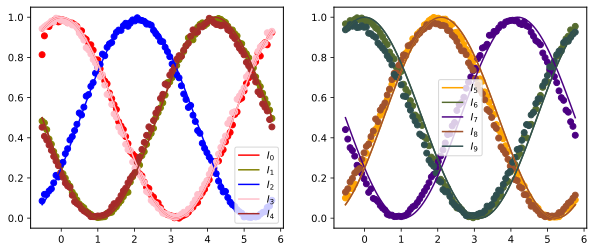

In [24]:
color = ['red', 'olive', 'blue', 'pink', 'brown', 'orange', 'darkolivegreen', 'indigo', 'sienna', 'darkslategrey']
ex = 'ex'
th = 'th'
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

for i in range(5):
    ax1.scatter(phase_swept, pop_beta[:, 1][i*length:(i+1)*length], color=color[i])
    ax1.plot(phase_swept, pop_beta_sim[:, 1][i*length:(i+1)*length], label=f'$I_{i}$', color=color[i])

ax1.legend()

for i in range(5, 10):
    ax2.scatter(phase_swept, pop_beta[:, 1][i*length:(i+1)*length], color=color[i])
    ax2.plot(phase_swept, pop_beta_sim[:, 1][i*length:(i+1)*length], label=f'$I_{i}$', color=color[i])

ax2.legend()

# Fit $\alpha$

In [37]:
alpha = pi-pi/7
beta = 0

In [38]:
phase_swept = np.linspace(-np.pi/6, -np.pi/6+2*np.pi, 100)
length = len(phase_swept)

U_sx01 = (-1j*(np.pi/2)/2*Lx01()).expm()
U_sx12 = (-1j*(np.pi/2)/2*Lx12()).expm()
U_sxp01 = (-1j*(np.pi/2)/2*Lx01()).expm()
U_sxm01 = (-1j*(-np.pi/2)/2*Lx01()).expm()

pop_alpha_sim = []

for reps in [0, 1, 2, 3, 4]:
    for phase in phase_swept:
        psi = ket0()
        psi = Z01(beta) * U_sx12 * Z12(3 * alpha) * U_sx01 * U_sx01 * psi
        for i in range(reps):
            psi = Z12(2 * alpha) * U_sxm01 * U_sxp01 * psi 
        psi = Z01(beta) * R12(pi/2, -phase) * psi
        pop0 = np.abs((ket0().dag() * psi).full()[0][0])**2
        pop1 = np.abs((ket1().dag() * psi).full()[0][0])**2
        pop2 = np.abs((ket2().dag() * psi).full()[0][0])**2
        pop_alpha_sim.append([pop0, pop1, pop2])

pop_alpha_sim = np.array(pop_alpha_sim)

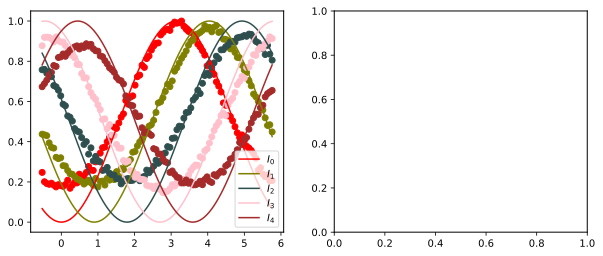

In [39]:
color = ['red', 'olive', 'darkslategrey', 'pink', 'brown', 'orange', 'darkolivegreen', 'indigo', 'sienna', 'blue']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

for i in range(5):
    ax1.scatter(phase_swept, pop_alpha[:, 1][i*length:(i+1)*length], color=color[i])
    ax1.plot(phase_swept, pop_alpha_sim[:, 1][i*length:(i+1)*length], label=f'$I_{i}$', color=color[i])

ax1.legend()

# for i in range(5, 10):
#     ax2.scatter(phase_swept, pop_alpha[:, 1][i*length:(i+1)*length], color=color[i])
#     ax2.plot(phase_swept, pop_alpha_sim[:, 1][i*length:(i+1)*length], label=f'$I_{i}$', color=color[i])

# ax2.legend()